In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

tf.__version__

'2.10.0'

*Exercise 10.* Train a deep MLP on the MNIST dataset (you can load it using keras.datasets.mnist.load_data(). See if you can get over 98% precision. Try searching for the optimal learning rate by using the approach presented in this chapter (i.e., by growing the learning rate exponentially, plotting the loss, and finding the point where the loss shoots up). Try adding all the bells and whistles—save checkpoints, use early stopping, and plot learning curves using TensorBoard.

In [2]:
# Load data first
(x_train_orig, y_train_orig), (x_test_orig, y_test_orig) = tf.keras.datasets.mnist.load_data()
assert x_train_orig.shape == (60000, 28, 28)
assert x_test_orig.shape == (10000, 28, 28)
assert y_train_orig.shape == (60000,)
assert y_test_orig.shape == (10000,)

In [3]:
# Scale down pixels into 0 to 1 values
x_train_scaled, x_test_scaled = x_train_orig / 255., x_test_orig / 255.

In [4]:
# Split train set into train and validation set
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(x_train_scaled, y_train_orig, test_size=0.2, random_state=42)
X_test, y_test = x_test_scaled, y_test_orig

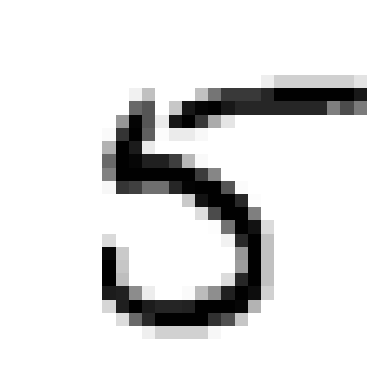

5

In [5]:
# Plot the first number from train set
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()
y_train[0]

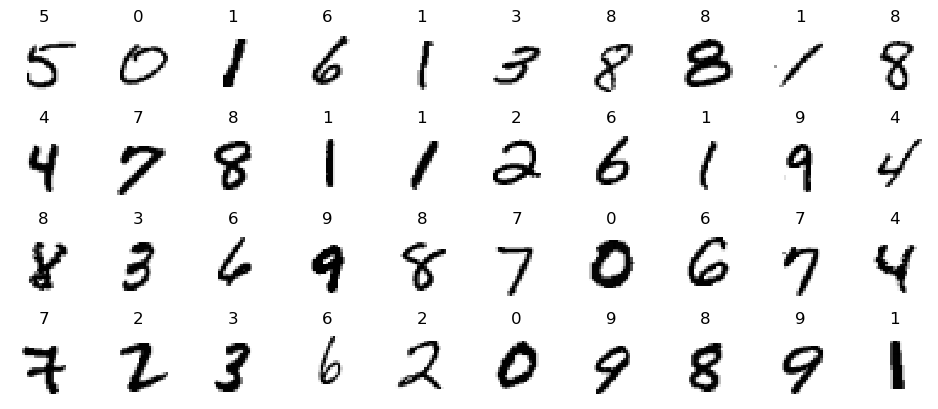

In [6]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(y_train[index], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [7]:
# Callback that increases lr after each batch

K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

exp_lr_cb = ExponentialLearningRate(factor=1.005)

In [8]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

# model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
# model.add(tf.keras.layers.Dense(300, activation="relu"))
# model.add(tf.keras.layers.Dense(100, activation="relu"))
# model.add(tf.keras.layers.Dense(10, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 300)               90300     
                                                                 
 dense_2 (Dense)             (None, 10)                3010      
                                                                 
Total params: 328,810
Trainable params: 328,810
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3),  # or 0.001
    metrics=["accuracy"]
)

In [10]:
history = model.fit(X_train, y_train,
                    epochs=1,
                    validation_data=(X_val, y_val),
                    callbacks=[exp_lr_cb])

1500/1500 [==============================] - 3s 2ms/step - loss: nan - accuracy: 0.6765 - val_loss: nan - val_accuracy: 0.0979


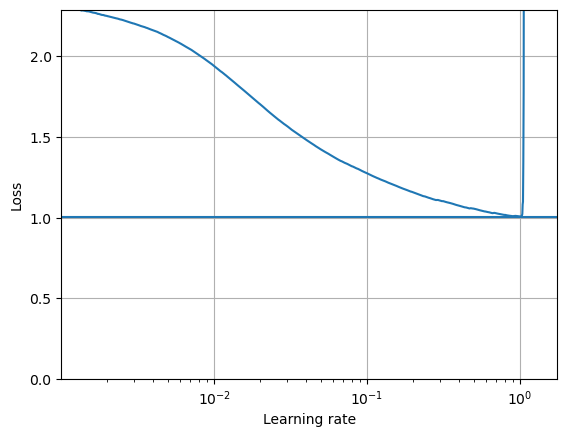

In [11]:
plt.plot(exp_lr_cb.rates, exp_lr_cb.losses)
plt.gca().set_xscale('log')
plt.hlines(min(exp_lr_cb.losses), min(exp_lr_cb.rates), max(exp_lr_cb.rates))
plt.axis([min(exp_lr_cb.rates), max(exp_lr_cb.rates), 0, exp_lr_cb.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.show()

In [12]:
min_loss = min(exp_lr_cb.losses)
min_loss_index = exp_lr_cb.losses.index(min_loss)
min_loss_lr = exp_lr_cb.rates[min_loss_index]
min_loss_lr

1.0201328

In [13]:
learning_rate = min_loss_lr / 2
learning_rate

0.5100663900375366

In [14]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [15]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
              metrics=["accuracy"])

In [16]:
import os

run_index = 1
run_logdir = os.path.join(os.curdir, "logdir", "run_{:03d}".format(run_index))
run_logdir

'.\\logdir\\run_001'

In [17]:
# Callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("model.h5", save_best_only=True)
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
early_stop_cb = tf.keras.callbacks.EarlyStopping(patience=10)  # If val_loss doesn't improve at all for 3 epochs stop training

In [18]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[checkpoint_cb, early_stop_cb, tensorboard_cb])

Epoch 1/100
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3232 - accuracy: 0.9032 - val_loss: 0.1523 - val_accuracy: 0.9538
Epoch 2/100
1500/1500 [==============================] - 2s 1ms/step - loss: 0.1283 - accuracy: 0.9617 - val_loss: 0.1268 - val_accuracy: 0.9628
Epoch 3/100
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0970 - accuracy: 0.9712 - val_loss: 0.1478 - val_accuracy: 0.9544
Epoch 4/100
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0775 - accuracy: 0.9762 - val_loss: 0.1126 - val_accuracy: 0.9690
Epoch 5/100
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0619 - accuracy: 0.9807 - val_loss: 0.1114 - val_accuracy: 0.9705
Epoch 6/100
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0531 - accuracy: 0.9831 - val_loss: 0.1246 - val_accuracy: 0.9699
Epoch 7/100
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0496 - accuracy: 0.9844 - val_loss: 0.1196 - val_ac

In [19]:
model = tf.keras.models.load_model("model.h5") # rollback to best model
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 784us/step - loss: 0.1063 - accuracy: 0.9720


[0.10626589506864548, 0.972000002861023]

In [20]:
%load_ext tensorboard
%tensorboard --logdir=./logdir --port=6006

Launching TensorBoard...